In [1]:
import numpy as np
import matplotlib.pyplot as plt

import xtrack as xt
import xcoll as xc
import xobjects as xo
import xpart as xp

In [2]:
line = xt.Line.from_json('injection_thin_approx_ap2.json')
#line = xt.Line.from_json('lhc_run3_b1.json')

Loading line from dict:   0%|          | 0/31427 [00:00<?, ?it/s]

Done loading line from dict.           


In [4]:
num_turns = 3000
num_particles = 500

nemitt_x = 3.5e-6
nemitt_y = 3.5e-6
amplitude_adt = 0.12

In [5]:
print('Install collimator')
coll = xc.EverestCollimator(length=1.83, gap=5, material=xc.materials.Carbon) # length is 1.83
line.collimators.install('tcsm.51932', coll)

#Make aperture for collimator and update line
coll_ap = xt.LimitRectEllipse(a=0.05, b=0.05, max_x=0.05, max_y=0.05) 
coll_ap_names = ['tcsm.51932_aper_upstream', 'tcsm.51932_aper_downstream']
coll_ap_idx = [line.element_names.index('tcsm.51932'), line.element_names.index('tcsm.51932') + 1]

max_length = max(max(map(len, line.element_names)), max(map(len, coll_ap_names)))
element_names = np.array(line.element_names, dtype=f'<U{max_length}')
names = np.array(coll_ap_names, dtype=f'<U{max_length}')
element_names = np.insert(element_names, coll_ap_idx, coll_ap_names)

insert_colls = {name: coll_ap for name in coll_ap_names}

line.element_names = element_names.tolist()
line.element_dict = {**line.element_dict, **insert_colls}

Install collimator
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/30277 [00:00<?, ?it/s]

In [6]:
adt = xc.BlowUp.install(line, name=f'adt_H_blowup', at_s=line.get_s_position('adkcv.32171'), plane='H', stop_at_turn=num_turns,
                        amplitude=amplitude_adt, use_individual_kicks=True)

In [7]:
df_with_coll = line.check_aperture()

Checking aperture:   0%|          | 0/30280 [00:00<?, ?it/s]

Done checking aperture.           
0 thin elements miss associated aperture (upstream):
[]
0 thick elements miss associated aperture (upstream or downstream):
[]


In [8]:
line.build_tracker()
tw = line.twiss()
sigma_x = np.sqrt(nemitt_x*tw.betx/line.particle_ref.gamma0)
sigma_y = np.sqrt(nemitt_y*tw.bety/line.particle_ref.gamma0)

line.collimators.assign_optics(twiss=tw, nemitt_x=nemitt_x, nemitt_y=nemitt_y)
adt.calibrate_by_emittance(nemitt=nemitt_x, twiss=tw)
line.optimize_for_tracking()

# Start interaction record
impacts = xc.InteractionRecord.start(line=line, record_impacts=True)

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [59]:
num_particles = 50_000
x_norm = []
px_norm = []
while True:
    this_x_norm = np.random.normal(size=10_000_000)
    this_px_norm = np.random.normal(size=10_000_000)
    mask = np.sqrt(this_x_norm**2 + this_px_norm**2) >= 4
    x_norm.extend(this_x_norm[mask])
    px_norm.extend(this_px_norm[mask])
    if len(x_norm) >= num_particles:
        x_norm = np.array(x_norm[:num_particles])
        px_norm = np.array(px_norm[:num_particles])
        break

y_norm = np.random.normal(size=num_particles)
py_norm = np.random.normal(size=num_particles)

line.build_particles(x_norm=x_norm, px_norm=px_norm, y_norm=y_norm, py_norm=py_norm)

KeyboardInterrupt: 

In [43]:
line.scattering.disable()
part = xp.generate_matched_gaussian_bunch(num_particles=num_particles, total_intensity_particles=2.2e11,
                                          nemitt_x=3.5e-6, nemitt_y=3.5e-6, sigma_z=0.224, line=line) #Flat bottom: 0.224, flat top: 0.124

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
*** Maximum RMS bunch length 0.23305719228461633m.
... distance to target bunch length: -2.2400e-01
... distance to target bunch length: 4.2397e-03
... distance to target bunch length: 4.0509e-03
... distance to target bunch length: -5.4164e-03
... distance to target bunch length: 1.6934e-03
... distance to target bunch length: -3.8711e-04
... distance to target bunch length: 6.2540e-05
... distance to target bunch length: 1.9666e-06
... distance to target bunch length: -3.5749e-10
... distance to target bunch length: 9.4807e-08
--> Bunch length: 0.22399999964250913
--> Emittance: 0.34322710188738503


In [12]:
final_res = {}
prev_res = {}
dead_idx = []

line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))

line.scattering.enable()
adt.activate()
for turn in range(num_turns):
    if turn%100==0:
        print(f'Turn {turn}')
    line.track(part, turn_by_turn_monitor='ONE_TURN_EBE')
    res = line.record_last_track
    ids = part.particle_id[part.state<=0]
    if ids.size>0:
        for idx in ids:
            if idx not in dead_idx:
                dead_idx.append(idx)
                if turn not in final_res:
                    final_res[turn] = {}
                #this_idx = res.particle_id.index(idx)
                this_idx = int(np.where(np.any(res.particle_id==idx, axis=1))[0][0])
                final_res[turn][idx] = {
                    'x': res.x[this_idx].copy(),
                    'y': res.y[this_idx].copy()
                }
                if turn > 0:
                    if turn-1 not in final_res:
                        final_res[turn-1] = {}
                    prev_idx = int(np.where(np.any(prev_res['pid']==idx, axis=1))[0][0])
                    final_res[turn-1][idx] = {
                        'x': prev_res['x'][prev_idx].copy(),
                        'y': prev_res['y'][prev_idx].copy()
                    }
    prev_res = {
        'x': res.x.copy(),
        'y': res.y.copy(),
        'pid': res.particle_id.copy()
    }
    del res
adt.deactivate()
line.scattering.disable()

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Turn 0
Turn 100
Turn 200
Turn 300
Turn 400
Turn 500
Turn 600
Turn 700
Turn 800
Turn 900
Turn 1000
Turn 1100
Turn 1200
Turn 1300
Turn 1400
Turn 1500
Turn 1600
Turn 1700
Turn 1800
Turn 1900
Turn 2000
Turn 2100
Turn 2200
Turn 2300
Turn 2400
Turn 2500
Turn 2600
Turn 2700
Turn 2800
Turn 2900


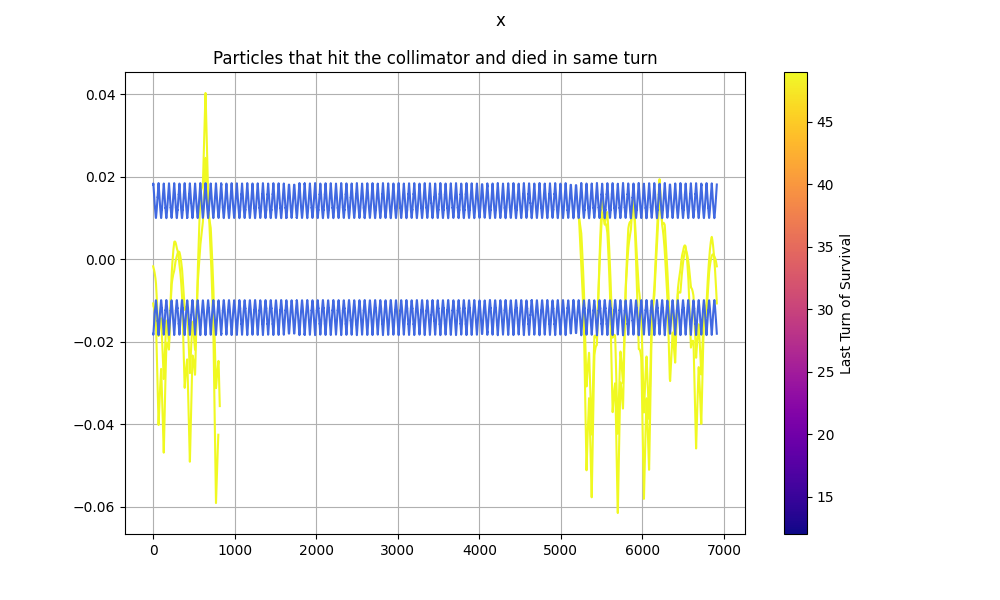

In [42]:
%matplotlib ipympl

impacts_df = impacts.to_pandas()

coll_id = impacts._coll_ids['tcsm.51932']
coll_s = line.get_table().s[coll_id]

hit_ids = np.unique(impacts.to_pandas().id_before)
died_on_aperture = part.particle_id[part.state==0]
# died_far_from_coll = part.particle_id[(part.s < coll_s) | (part.s > coll_s + 30)]
died_far_from_coll = part.particle_id[(part.s < 1000) & (part.s > 500)]
pids = np.intersect1d(hit_ids, np.intersect1d(died_on_aperture, died_far_from_coll))

turns = {int(pid): [int(impacts_df.turn[impacts_df.id_before==pid].min()), int(part.at_turn[part.particle_id==pid][0])]
         for pid in pids}

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

cmap = plt.cm.plasma # Choose a colormap (e.g., 'viridis', 'plasma', 'coolwarm', etc.)
norm = plt.Normalize(vmin=min(turns), vmax=max(turns))

for (pid, turn) in turns.items():
    end_id = part.at_element[part.particle_id==pid][0]
    color = cmap(norm(turn[1]))
    for this_turn in range(turn[0], turn[1]+1):
        if this_turn in final_res and pid in final_res[this_turn]:
            if this_turn==turn[0] and this_turn==turn[1]:
                ax.plot(line.get_table().s[coll_id:end_id+1], final_res[this_turn][pid]['x'][coll_id:end_id+1], color=color)
            elif this_turn==turn[0]:
                ax.plot(line.get_table().s[coll_id:], final_res[this_turn][pid]['x'][coll_id:], color=color)
            elif this_turn==turn[1]:
                ax.plot(line.get_table().s[:end_id+1], final_res[this_turn][pid]['x'][:end_id+1], color=color)
            else:
                ax.plot(line.get_table().s, final_res[this_turn][pid]['x'], color=color)

ax.set_title('Particles that hit the collimator and died in same turn')
# ax[1].set_title('Particles that hit the collimator and died in next turn')
for axis in [ax]:
    axis.grid()
    axis.plot(tw.s, 5*sigma_x, color='royalblue', linestyle='-')
    axis.plot(tw.s, -5*sigma_x, color='royalblue', linestyle='-')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for colorbar
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', label="Last Turn of Survival")

plt.suptitle('x')
plt.show()

In [39]:
died_far_from_coll

array([49, 12])

In [27]:
np.unique(part.state, return_counts=True)

(array([-331,    0,    1]), array([322, 146,  32]))

In [30]:
hit_ids = np.unique(impacts.to_pandas().id_before)
died_on_aperture = part.particle_id[part.state==0]
set(died_on_aperture) - set(hit_ids)

set()